<a href="https://colab.research.google.com/github/YuriGribauskasDenis/NetworkTopologies/blob/main/MobileNetFamilyTopologies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import keras.backend as BCKN
from keras.models import Model, Sequential
from keras.layers import Input, Concatenate
from keras.layers import Dense, Conv2D, DepthwiseConv2D, Dropout, Flatten
from keras.layers import GlobalAveragePooling2D, Reshape
from keras.layers import ReLU, Softmax, LeakyReLU
from keras.layers import BatchNormalization as BN
from keras.utils.vis_utils import plot_model

**Mobile Net**

In [2]:
def MobNet (shape, num_classes, alpha=1, ro=1, filter_one=32):

  #alpha should be 1/4, 1/2, 3/4, 1
  #basically between 0 and 1
  #it is a reduce multiplyer of net arcitecture
  #ro is reduce multiplyer of input image
  #also between 0 and 1

  #also additionally we included the number of filters to begin with
  #instead of 32 we can put another minimum 16 and then we grow it like 2**n

  #remember to reshape the image accordingly

  #block that puts batch normalization and relu
  #because we are tired of writing it each time
  #relu comes after batch normalization cause we don't want to loose info
  def BNR(model):
    model = BN() (model)
    model = ReLU() (model)
    return model

  #standart block
  #you guessed it each convolution is proceeded with
  #batch normalization and linear rectifier relu
  def CBNR(model, filters, kernal, stride=1, padd='same'):
    model = Conv2D (filters, kernal, strides=stride, padding=padd) (model)
    model = BNR(model)
    return model

  #combo block
  #deepwise convolution, in this way we save computational potency
  #instead of one big convolutional block we brake it into two
  #the first one is deepwise second is simple convolution
  #less coeficients appear in this way
  #too bad we did not perserve time to play with permute in all these exercises
  #first convolution as easch convolution in this method
  #is proceeded with batch normalization and relu
  #and standart block inside
  #we mean look at the name
  #it is very self explainatory DCBNRCBNR
  #for those to whom it is hard to read this
  #we put a down underline separator
  def DCBNR_CBNR(model, filters, stride=1, padd='same'):
    model = DepthwiseConv2D(3, strides=stride, padding=padd) (model)
    model = BNR(model)
    model = CBNR(model, filters, 1)
    return model

  #we fill the arcitecture of light net
  def fill(alpha=1, filters=32):
    new_list = []
    if filters<16:
      filters = 32
    if alpha<=0 or 1<alpha:
        alpha=0.5
    for n in range(6):
        new_list.append(int(filters*alpha*2** n))
    return new_list

  if ro<=0 or 1<ro:
    ro=0.5
  tmp=list(int(s*ro) for s in shape[:-1])
  tmp.append(shape[-1])
  shape=tuple(tmp)

  first = Input(shape)
  #arch stends for arcitecture
  arch = fill(alpha, filter_one)
  #it seems like we can imagine a better automatization
  #like one complex cycle
  #because number of filters frows in a simple row a(n)=2^n
  #but at this point we have not figured out it
  #and from another point of view it is more readable
  #and corelates strongly to paper table
  model = CBNR(first, arch[0], 7, 2)
  model = DCBNR_CBNR(model, arch[1])
  model = DCBNR_CBNR(model, arch[2], 2)
  model = DCBNR_CBNR(model, arch[2])
  model = DCBNR_CBNR(model, arch[3], 2)
  model = DCBNR_CBNR(model, arch[3])
  model = DCBNR_CBNR(model, arch[4], 2)
  for _ in range (5):
    model = DCBNR_CBNR(model, arch[4])
  model = DCBNR_CBNR(model, arch[5], 2)
  #this one is strange. in the paper it is said to have stride step 2
  #but the dimentions say it has to have stride = 1
  model = DCBNR_CBNR(model, arch[5])

  #tail
  model = GlobalAveragePooling2D() (model)
  model = Dense(num_classes) (model)
  last = Softmax() (model)
  final = Model(first, last)

  return final

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 8)         400       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 8)        32        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 50, 50, 8)         0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 50, 50, 8)        80        
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 8)        32    

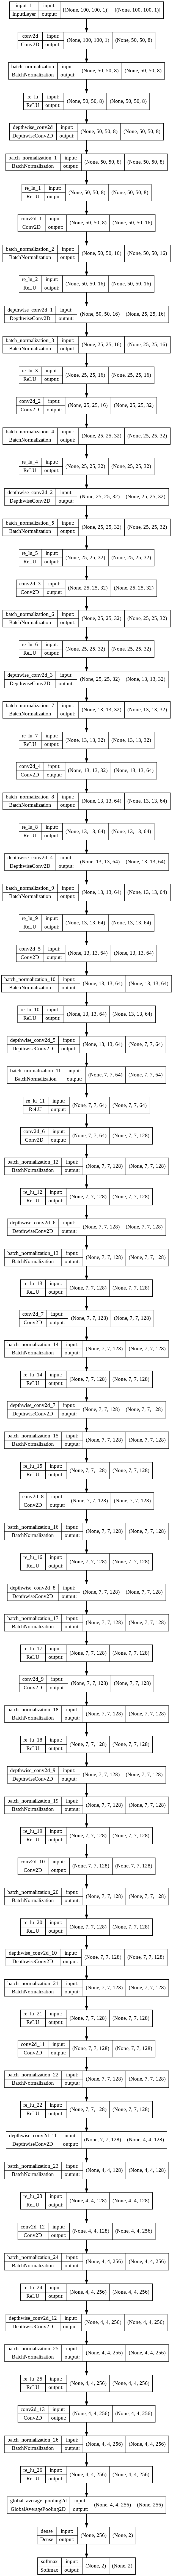

In [3]:
shape = (100, 100, 1)
num_classes = 2
alpha=0.25
romashka=1
first_filter = 16
BCKN.clear_session()
model = MobNet(shape, num_classes, alpha, romashka)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Mini CNN**

Minimalistic CNN-based ensemble model for gender prediction from face images Grigory Antipov, Sid-Ahmed Berrania, Jean-Luc Dugelay

In [6]:
from keras.layers import Dropout, Flatten
from keras.layers import MaxPooling2D

In [7]:
def MCNN (shape, num_classes, arch_list=(0,2,2), FC=512, d=0):

  #these three parameters allow to build any topology from paper
  #sizes of both tuples have to be the same
  #for example if we want D we pass (1,1,0) 512
  #for J we pass (0,1,1) 8
  #for A we pass (0,2,1) 512
  #by default it is Starting CNN
  #also we can go outside the given A-M limitation
  #for example mimicing the mobile net we can pass (0,2,1) 4
  #because the biggest number of parameters comes from dense fully connected layer
  #reducing this value we can fil our net into 100k parameters 
  #we can reduce number of training parameters even further with dropout
  sizes = 16, 32, 64

  if len(arch_list) != 3 : arch_list = 0,2,2
  if FC < 0 and 512 < FC: FC = 512
  if d < 0 and 1 < d: d = 0

  #convolution relu
  #as paper suggests kernel is always 3
  def CR(model, filters, kernal=3, stride=1, padd='same'):
    model = Conv2D (filters, kernel_size=kernal, strides=stride, padding=padd) (model)
    model = ReLU() (model)
    return model

  #you guessed it: convolution relu convolution relu
  def CRCR(model, filters, kernal=3, stride=1, padd='same'):
    model = CR (model, filters, kernal, stride, padd)
    model = CR (model, filters, kernal, stride, padd)
    return model

  #mini cnn full block
  def MCNNFB (model):
    for s, a in zip(sizes, arch_list):
      for _ in range(a):
        model = CRCR(model, s)
        if d:
          model = Dropout(d) (model)
      model = MaxPooling2D(2) (model)
    return model

  first = Input(shape)
  model = MCNNFB(first)

  #tail
  model = Flatten() (model)
  if FC:
    model = Dense(FC) (model)
  model = ReLU() (model)
  if d:
    model = Dropout(d) (model)
  model = Dense(num_classes) (model)
  last = Softmax() (model)
  final = Model(first, last)

  return final

In [8]:
shape = (100, 100, 3)
num_classes = 2
BCKN.clear_session()
au_model_mcnn = MCNN (shape, num_classes)
au_model_mcnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 3)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 re_lu (ReLU)                (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 re_lu_1 (ReLU)              (None, 50, 50, 32)        0         
                                                             